_This is the Python code developed by Hang Zhang (@HangZhang6) to train a deep learning model to classify images as Cars or Trains. This is developed based on the assignments of course [Deep Learning by Google on UdaCity](https://www.udacity.com/course/deep-learning--ud730)._

## Step 1. Crawl Bing.com image search for classes of images

To practice Deep Learning on images, it is fundamental to have images to train DL models.

While there are many open-source scraper scripts available online, many of them are obsolete and do not work any more.

The [Bulk-Bing-Image-downloader](https://github.com/ostrolucky/Bulk-Bing-Image-downloader) is the one that I found easy to use and works smoothly. I tested it on April 24, 2017.

The bbid crawler runs on Python 3.x. 

To crawl the images impressed for a query keyword on Bing.com, you need to:

- Download the [bbid.py](https://raw.githubusercontent.com/ostrolucky/Bulk-Bing-Image-downloader/master/bbid.py) to your local machine. If you are using Windows machine, run the following PowerShell command to download it:
    
        wget https://raw.githubusercontent.com/ostrolucky/Bulk-Bing-Image-downloader/master/bbid.py -O bbid.py
    
    
- Run the following command to crawl the Bing image search page for a query (e.g., 'Cars') and output the impressed images to a designated directory (e.g., C:\Images\Cars):

        python bbid.py -s "Cars" -o C:\Images\Cars --filter
    
    Parameter --filter filters out the adult content from the search results. 

- Run it again for another search keyword (e.g., 'Trains') and output the images to another designated directory (e.g., C:\Images\Trains):

        python bbid.py -s "Trains" -o C:\Images\Trains --filter 

## Step 2: Resize Images

The crawled images are of different sizes, or even with different dimensions (some are gray-scaled with only 1 channel, some are 256-color scale with 3 channels). To train DL models on images, we need to resize them to be of the same size. In addition, because of the limitation of the memory on my laptop, I have to downsize the images so that later on the machine has enough memories to store and train the parameters of the DL models. 

In [2]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
from IPython.display import display, Image
from scipy import ndimage
from six.moves import cPickle as pickle
from PIL import Image
import random

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

In [17]:
def get_size(root_dir, folders):
    num_images = 0
    for folder in folders:
        folder = os.path.join(root_dir, folder)
        image_files = os.listdir(folder)
        num_images += len(image_files)
    image_size = np.ndarray(shape=(num_images,2), dtype=np.integer)
    img_counter = 0
    for folder in folders:
        folder = os.path.join(root_dir, folder)
        image_files = os.listdir(folder)
        for image in image_files:
            image_file = os.path.join(folder, image)
            try:
                image_data = ndimage.imread(image_file).astype(float)
                image_size[img_counter,:] = image_data.shape[0:2]
                img_counter += 1
            except IOError as e:
                print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    print("Totally %d images are scanned for sizes"%img_counter)
    avg_size = np.average(image_size, axis=0)
    print(avg_size)
    avg_size = [round(x) for x in avg_size] 
    return avg_size

def resize_image(image_file, width, height):
    try:
      pixel_depth = 255.0
      image = Image.open(image_file)
      im2 = image.resize((width, height), Image.ANTIALIAS)
      im2 = np.array(im2.getdata(),
                    np.uint8).reshape(im2.size[1], im2.size[0], 3)
      # randomly choose some images to show both before and after resizing, to make sure that 
      # the resizing is as expected
      rn = random.random()
      if rn < 0.002:
        f, axarr = plt.subplots(1, 2)
        image_data = ndimage.imread(image_file).astype(float)
        image_data = image_data / 255
        axarr[0].imshow(image_data)
        im2 = im2 / 255
        axarr[1].imshow(im2)
    except:
      print("Resizing failed on file %s"%image_file)
    return im2

def load_resize_images(root_dir, folder, width, height):
  """Load and resize the images."""
  pixel_depth = 255.0
  folder = os.path.join(root_dir, folder)
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), height, width, 3),
                         dtype=np.float16)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    filename, file_extension = os.path.splitext(image_file)
    if file_extension in [".jpg", ".JPG", ".jpeg"]:
      try:
        image_data = (ndimage.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
        if len(image_data.shape) == 3:
          if image_data.shape[2] != 3:
            print("Image file %s has %d channels, skipping"%(image_file, image_data.shape[2]))
          elif image_data.shape[0] < width or image_data.shape[1] < height:
            print("Image file %s is too small, skipping"%image_file)
          else:
            try:
              image_data = resize_image(image_file, width, height)
              dataset[num_images, :, :, :] = image_data
              num_images = num_images + 1
            except:
              print("Could not resize %s, skipping"%image_file)
        else:
          print("Image file %s only has %d dimensions, skipping"%(image_file, len(image_data.shape)))
      except IOError as e:
        print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    else:
      print("Image file %s is not a jpg file, skipping"%image_file)
  dataset = dataset[0:num_images, :, :, :]
  #dataset = (dataset - pixel_depth/2)/(pixel_depth/2)
  print("%d images in folder %s are added into the pickle file"%(num_images, folder))
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(root_dir, image_folders, width, height, force=False):
  dataset_names = []
  for folder in image_folders:
    set_filename = folder + '.pickle'
    set_filename = os.path.join(root_dir, set_filename)
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      
      dataset = load_resize_images(root_dir, folder, width, height)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

## Read and resize the images to an uniform and smaller size, and dump to pickles to future use

The uniform image size is only 100-by-80 pixels. I chose this size due to the memory limitation on my laptop. Images at gray scale, smaller than the desired target size in either dimension are neglected. 

Pickling C:\Projects\DX\Data\Images\Cars.pickle.
C:\Projects\DX\Data\Images\Cars
Image file C:\Projects\DX\Data\Images\Cars\185645_1_c2cs_raoulcaroule1_1_per16_.jpg has 4 channels, skipping
Image file C:\Projects\DX\Data\Images\Cars\1971-Dodge-Challenger-RT-Mopar-muscl.png is not a jpg file, skipping
Image file C:\Projects\DX\Data\Images\Cars\2015-hyundai-sonata-hybrid-limited-s.png is not a jpg file, skipping
Image file C:\Projects\DX\Data\Images\Cars\2740576-story_header_2_1416490086.png is not a jpg file, skipping
Resizing failed on file C:\Projects\DX\Data\Images\Cars\680.1.jpg
Could not resize C:\Projects\DX\Data\Images\Cars\680.1.jpg, skipping
Image file C:\Projects\DX\Data\Images\Cars\911-hero_980_420_assetsimageshertz-s.png is not a jpg file, skipping
Image file C:\Projects\DX\Data\Images\Cars\AudiSpringCollection3Cars.jpg has 4 channels, skipping
Image file C:\Projects\DX\Data\Images\Cars\blue-Jazz-360-panel04.png is not a jpg file, skipping
Image file C:\Projects\DX\Data\Imag

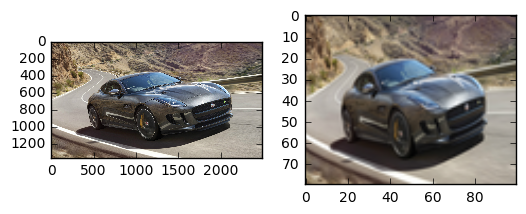

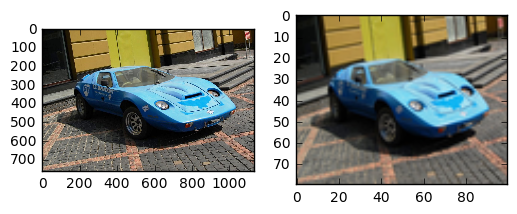

In [18]:
data_root = 'C:\Projects\DX\Data\Images' # Change me to store data elsewhere
image_dir = ['Cars','Trains']
#[width, height] = get_size(data_root, image_dir)
#ratio = 0.0001
width1 = 100
height1 = 80
dataset_names = maybe_pickle(data_root, image_dir, width1, height1)

## Step 3. Split the data (Cars and Trains) into training, validation, and testing sets

In [19]:
def make_arrays(nb_rows, width, height):
  if nb_rows:
    dataset = np.ndarray((nb_rows, width, height, 3), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, width, height, train_ratio = 0.7, validation_ratio = 0.15):
  num_classes = len(pickle_files)
  num_vehicles = [0]*num_classes
  for i in range(num_classes):
    with open(pickle_files[i], 'rb') as f:
      vehicle_set = pickle.load(f)
      num_vehicles[i] = vehicle_set.shape[0]
  total_vehicles = np.sum(num_vehicles)
  num_train = [int(round(float(x)*train_ratio)) for x in num_vehicles]
  num_valid = [int(round(float(x)*validation_ratio)) for x in num_vehicles]
  num_test = np.array(num_vehicles) - np.array(num_train) - np.array(num_valid)
  total_train = np.sum(num_train)
  total_valid = np.sum(num_valid)
  total_test = np.sum(num_test)
  print("There are %d, %d, %d train, validation, and test images."%(total_train, total_valid, total_test))
  test_dataset, test_labels = make_arrays(total_test, width, height)
  valid_dataset, valid_labels = make_arrays(total_valid, width, height)
  train_dataset, train_labels = make_arrays(total_train, width, height)
    
  start_v, start_trn, start_tst = 0, 0, 0
  for label, pickle_file in enumerate(pickle_files): # the first element in pickle_files will be label 0, 
                                                     # the second with label 1, etc      
    try:
      with open(pickle_file, 'rb') as f:
        vehicle_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(vehicle_set)
        train_vehicle = vehicle_set[0:num_train[label], :, :, :]
        train_dataset[start_trn:(start_trn+num_train[label]), :, :, :] = train_vehicle
        train_labels[start_trn:(start_trn+num_train[label])] = label
        start_trn += num_train[label]
                    
        valid_vehicle = vehicle_set[num_train[label]:(num_valid[label]+num_train[label]), :, :, :]
        valid_dataset[start_v:(start_v+num_valid[label]), :, :, :] = valid_vehicle
        valid_labels[start_v:(start_v+num_valid[label])] = label
        start_v += num_valid[label]
        
        test_vehicle = vehicle_set[(num_valid[label]+num_train[label]):num_vehicles[label], :, :, :]
        test_dataset[start_tst:(start_tst+num_test[label]), :, :, :] = test_vehicle
        test_labels[start_tst:(start_tst+num_test[label])] = label
        start_tst += num_test[label]
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return train_dataset, train_labels, valid_dataset, valid_labels, test_dataset, test_labels
            
            
train_dataset, train_labels, valid_dataset, valid_labels, test_dataset, test_labels = merge_datasets(
  dataset_names, height1, width1)
print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

There are 1157, 248, 247 train, validation, and test images.
Training: (1157, 80, 100, 3) (1157,)
Validation: (248, 80, 100, 3) (248,)
Testing: (247, 80, 100, 3) (247,)


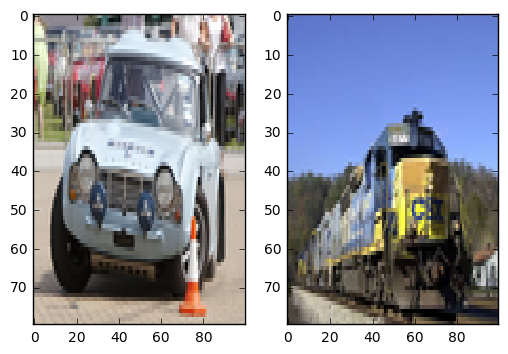

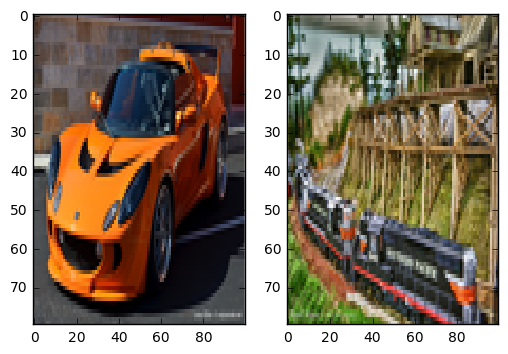

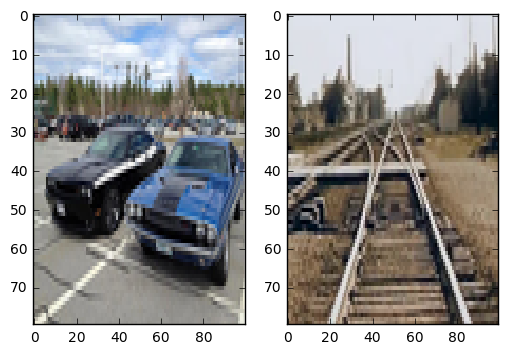

In [20]:
# Visualize two classes of images in each dataset
import matplotlib.image as mpimg
def visualize_two_class_images(dataset):
    f, axarr = plt.subplots(1, 2)
    image_data = dataset[0,:,:,:]
    image_data = image_data / 255
    axarr[0].imshow(image_data, interpolation='none', aspect='auto')
    image_data = dataset[-1,:,:,:]
    image_data = image_data / 255
    axarr[1].imshow(image_data, interpolation='none', aspect='auto')

visualize_two_class_images(train_dataset)
visualize_two_class_images(valid_dataset)
visualize_two_class_images(test_dataset)

## Step 4. Save both training, validation, and testing data into a single pickle file

In [21]:
pickle_file = os.path.join(data_root, 'carsTrains.pickle')

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise